In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

In [2]:
import os
import scipy.io

In [3]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps']
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps']


In [4]:
# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols']
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols']

In [5]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [6]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

In [7]:
esc_polys_interp.shape

(86, 3, 1225)

In [8]:
cnc_polys_interp.shape

(86, 3, 1757)

In [9]:
esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [10]:
import umap


In [11]:
# Initialize UMAP model
umap_model = umap.UMAP(n_components=2)
# Fit UMAP on the first dataset
umap_model.fit(all_maps_interp_flat)
esc_umap = umap_model.transform(esc_maps_interp_flat)
cnc_umap = umap_model.transform(cnc_maps_interp_flat)
all_umap = umap_model.transform(all_maps_interp_flat)

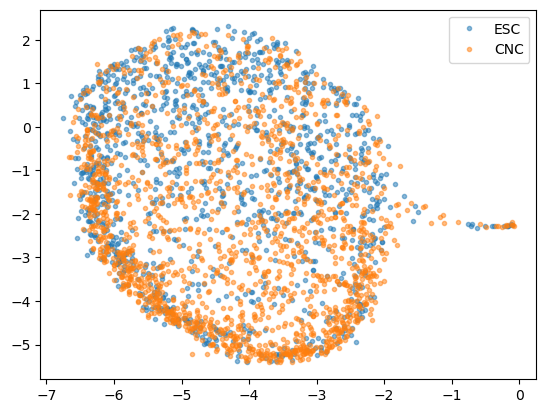

In [12]:
# Plot UMAP
plt.plot(esc_umap[:, 0], esc_umap[:, 1], '.', label='ESC', alpha=0.5)
plt.plot(cnc_umap[:, 0], cnc_umap[:, 1], '.', label='CNC', alpha=0.5)

plt.legend()

In [13]:
esc_pd = pd.DataFrame(esc_umap, columns=['UMAP1', 'UMAP2'])
esc_pd = esc_pd.assign(label='ESC')
cnc_pd = pd.DataFrame(cnc_umap, columns=['UMAP1', 'UMAP2'])
cnc_pd = cnc_pd.assign(label='CNC')
all_pd = pd.concat([esc_pd, cnc_pd])

In [14]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240724'

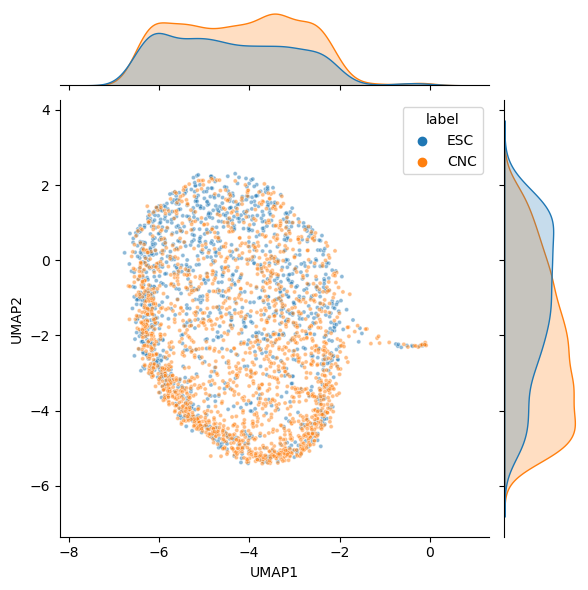

In [15]:
sns.jointplot(data=all_pd, x='UMAP1', y='UMAP2', hue='label', alpha=0.5, marker='.')
plt.savefig(os.path.join(save_dir, 'umap.png'), dpi=300, bbox_inches='tight')

In [16]:
# Plot the median distance maps of ESC and CNC
esc_median = np.median(esc_maps_interp, axis=0)
cnc_median = np.median(cnc_maps_interp, axis=0)

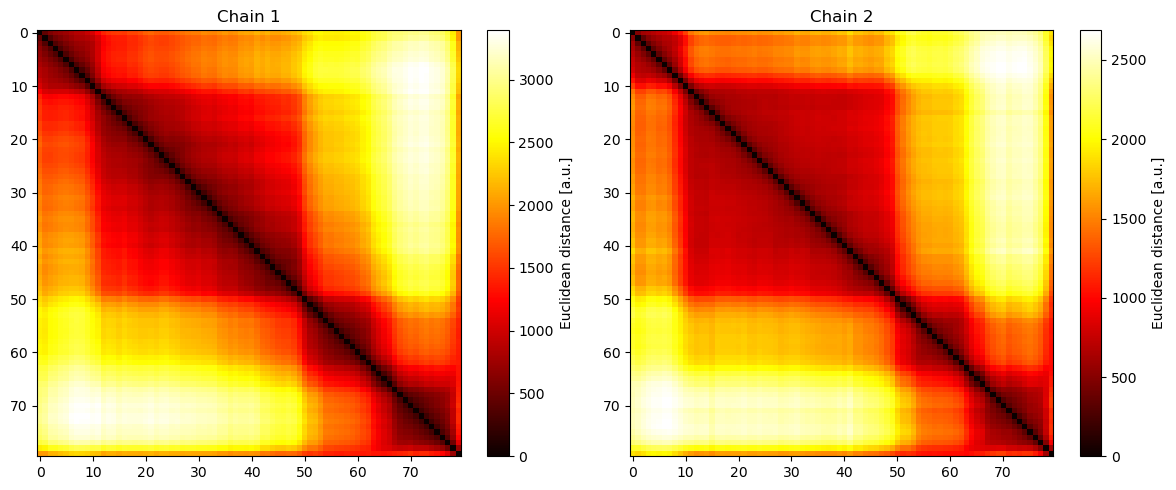

In [17]:
compare_distance_maps(esc_median, cnc_median)

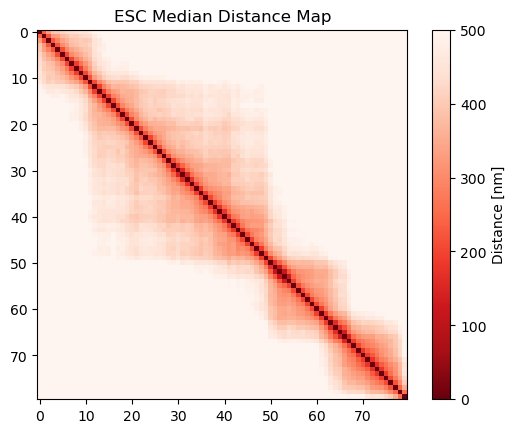

In [18]:
plt.imshow(esc_median, cmap='Reds_r', vmax=500)
plt.colorbar(label='Distance [nm]')
plt.title('ESC Median Distance Map')
plt.savefig(os.path.join(save_dir, 'esc_median_distance_map.png'), dpi=300, bbox_inches='tight')

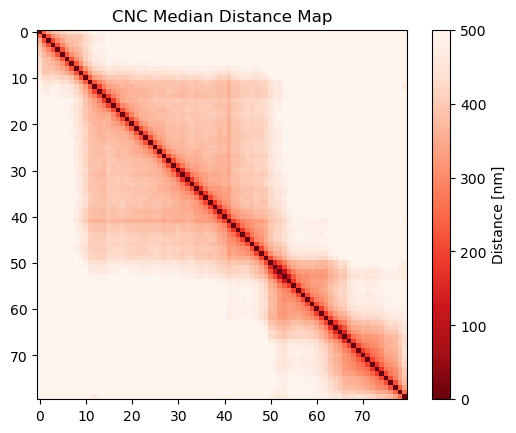

In [19]:
plt.imshow(cnc_median, cmap='Reds_r', vmax=500)
plt.colorbar(label='Distance [nm]')
plt.title('CNC Median Distance Map')
plt.savefig(os.path.join(save_dir, 'cnc_median_distance_map.png'), dpi=300, bbox_inches='tight')

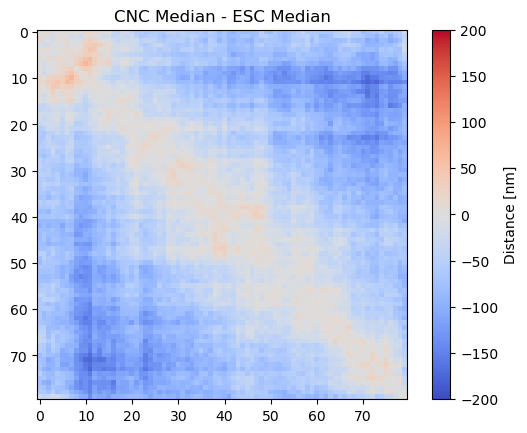

In [20]:
plt.imshow(cnc_median - esc_median, cmap='coolwarm', vmax=200, vmin=-200)
plt.colorbar(label='Distance [nm]')
plt.title('CNC Median - ESC Median')
plt.savefig(os.path.join(save_dir, 'cnc_minus_esc_distance_map.png'), dpi=300, bbox_inches='tight')

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


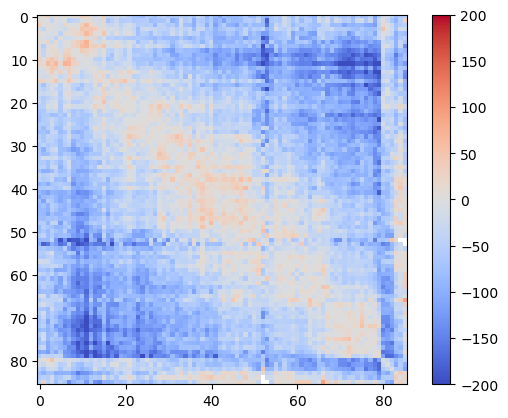

In [21]:
plt.imshow(np.nanmedian(cnc_maps, axis=2) - np.nanmedian(esc_maps, axis=2), cmap='coolwarm', vmax=200, vmin=-200)
plt.colorbar()

In [22]:
# Contact frequencies map 
esc_contact_freq = np.nanmean(esc_maps < 250, axis=2)
cnc_contact_freq = np.nanmean(cnc_maps < 250, axis=2)

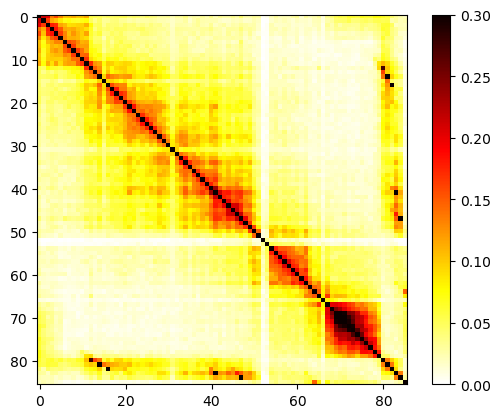

In [23]:
plt.imshow(esc_contact_freq, cmap='hot_r', vmax=0.3)
plt.colorbar()

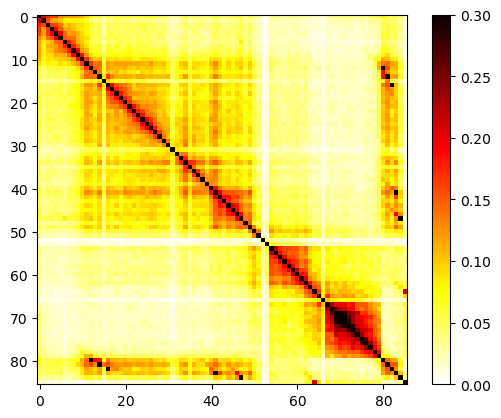

In [24]:
plt.imshow(cnc_contact_freq, cmap='hot_r', vmax=0.3)
plt.colorbar()

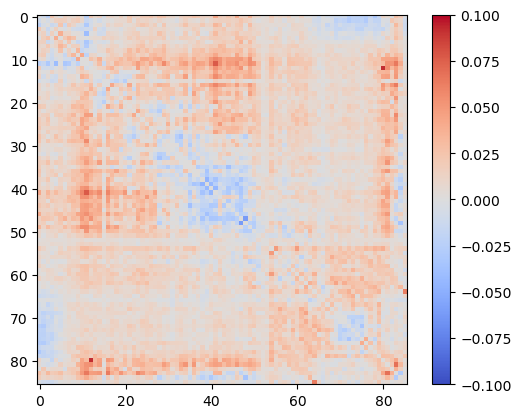

In [25]:
plt.imshow(cnc_contact_freq - esc_contact_freq, cmap='coolwarm', vmax=0.1, vmin=-0.1)
plt.colorbar()

In [26]:
esc_contact_freq_interp = np.mean(esc_maps_interp < 250, axis=0)
cnc_contact_freq_interp = np.mean(cnc_maps_interp < 250, axis=0)

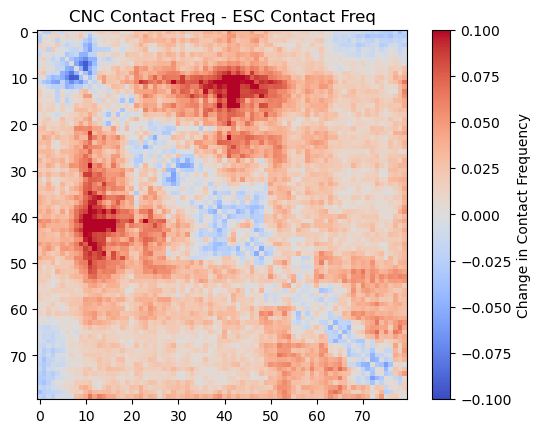

In [27]:
plt.imshow(cnc_contact_freq_interp - esc_contact_freq_interp, cmap='coolwarm', vmax=0.1, vmin=-0.1)
plt.colorbar(label='Change in Contact Frequency')
plt.title('CNC Contact Freq - ESC Contact Freq')
plt.savefig(os.path.join(save_dir, 'cnc_minus_esc_contact_freq.png'), dpi=300, bbox_inches='tight')

In [28]:
# Load in BGMM results from pickle file
pickle_file = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/bgmm_models_250.pkl'
bgmm_results = pickle.load(open(pickle_file, 'rb'))

In [29]:
fit_result = bgmm_results['bgmm_all']

In [30]:
num_cells, _  = all_maps_interp_flat.shape

In [31]:
sort_indices = np.argsort(fit_result.weights_)[::-1]

In [32]:
means_sorted = fit_result.means_[sort_indices, :]

In [33]:
cluster = fit_result.predict(all_maps_interp_flat)

In [34]:
num_comp_sorted = [np.sum(cluster == i) for i in sort_indices]

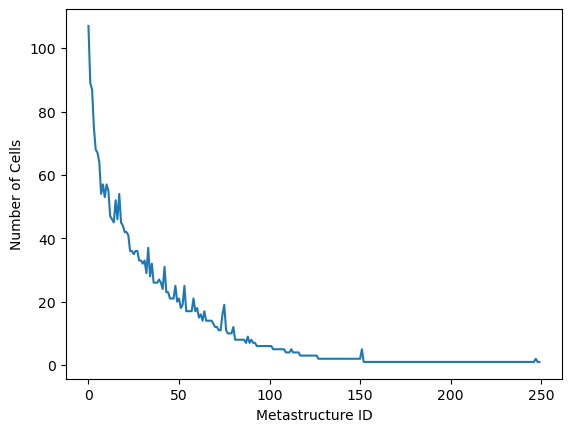

In [35]:
plt.plot(num_comp_sorted)
plt.xlabel('Metastructure ID')
plt.ylabel('Number of Cells')
plt.savefig(os.path.join(save_dir, 'num_cells_per_metastructure.png'), dpi=300, bbox_inches='tight')

NameError: name 'num_poly_comp_sorted' is not defined

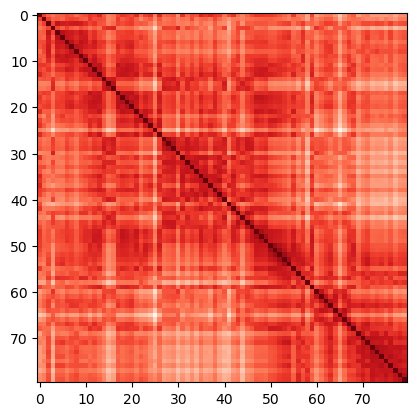

In [36]:
i = -1
plt.imshow(means_sorted[i].reshape(-1, 80), cmap='Reds_r')
plt.title('{}th most common polymer: {}'.format(i+1, num_poly_comp_sorted[i]))
plt.colorbar()

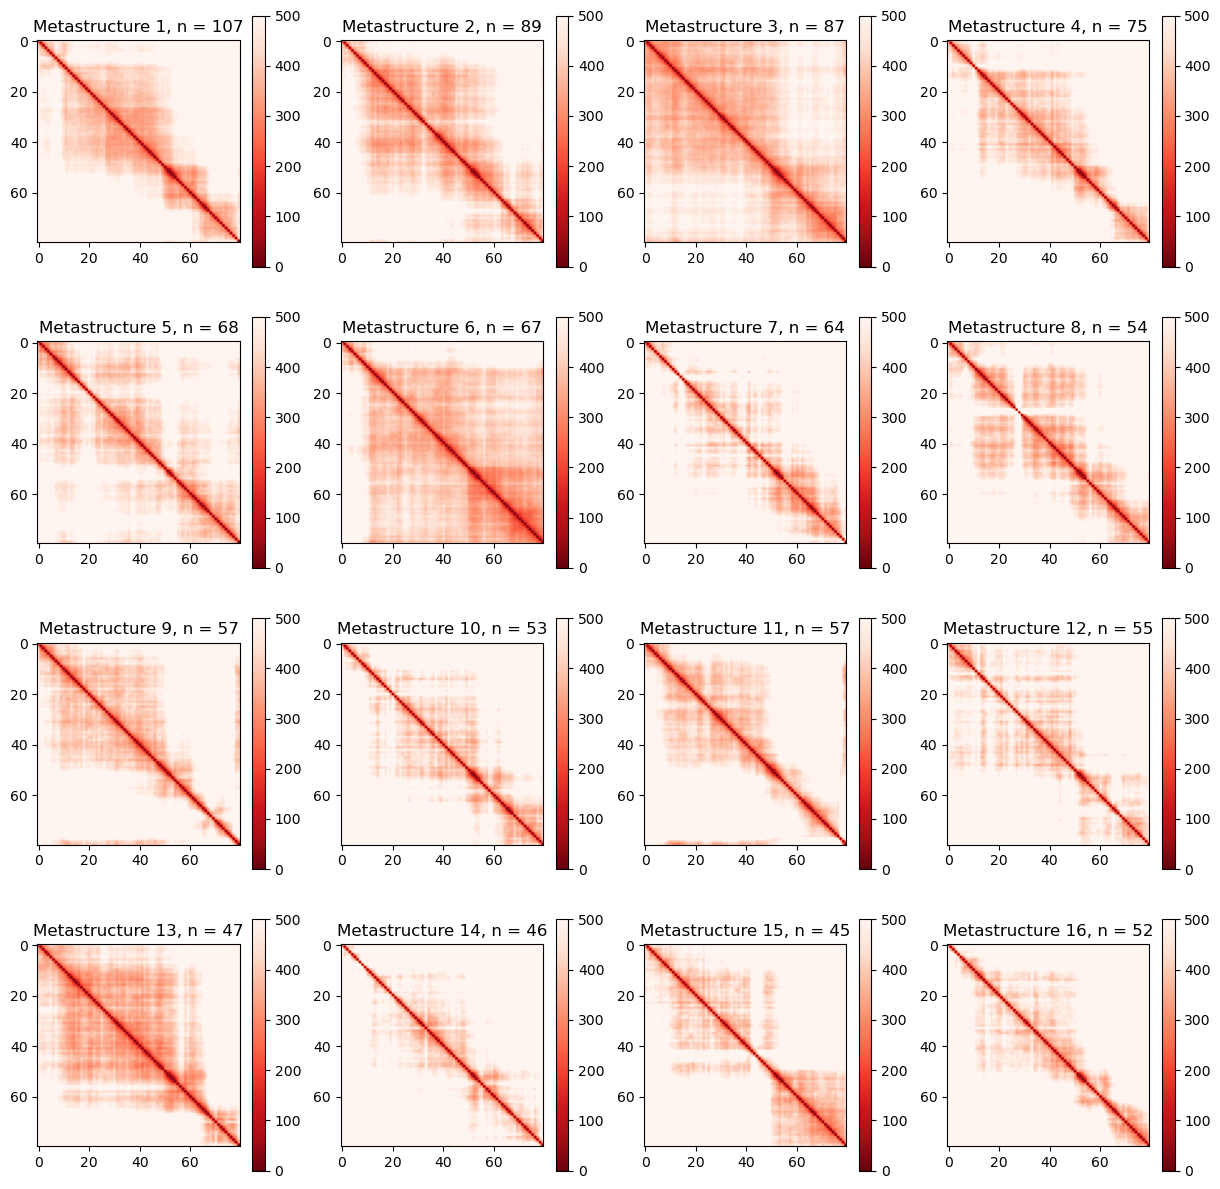

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(means_sorted[i].reshape(-1, 80), cmap='Reds_r', vmax=500)
    ax.set_title(f'Metastructure {i+1}, n = {round(num_comp_sorted[i])}')
    fig.colorbar(im, ax=ax)
plt.savefig(os.path.join(save_dir, 'most_common_metastructures.png'), dpi=300, bbox_inches='tight')

In [38]:
num_esc_cells = esc_maps_interp_flat.shape[0]
num_cnc_cells = cnc_maps_interp_flat.shape[0]

In [39]:
esc_cells_part = cluster[:num_esc_cells]
cnc_cells_part = cluster[num_esc_cells:]

In [40]:
num_comp_sorted_esc = np.array([np.sum(esc_cells_part == i) for i in sort_indices])
num_comp_sorted_cnc = np.array([np.sum(cnc_cells_part == i) for i in sort_indices])

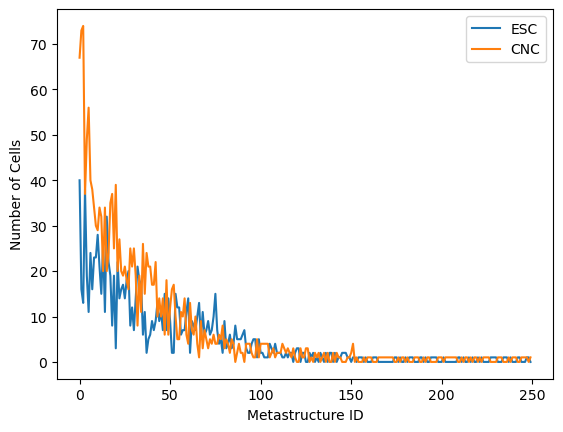

In [42]:
plt.plot(num_comp_sorted_esc, label='ESC')
plt.plot(num_comp_sorted_cnc, label='CNC')
plt.xlabel('Metastructure ID')
plt.ylabel('Number of Cells')
plt.legend()
plt.savefig(os.path.join(save_dir, 'num_cells_per_metastructure_esc_cnc.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_328473/844318578.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(num_comp_sorted_cnc/num_comp_sorted_esc)


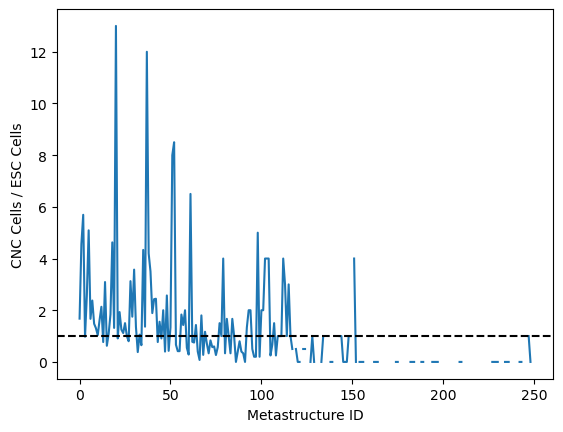

In [45]:
plt.plot(num_comp_sorted_cnc/num_comp_sorted_esc)
plt.axhline(1, color='black', linestyle='--')
plt.xlabel('Metastructure ID')
plt.ylabel('CNC Cells / ESC Cells')
plt.savefig(os.path.join(save_dir, 'cnc_esc_ratio_per_metastructure.png'), dpi=300, bbox_inches='tight')

In [ ]:
# Maps that are enriched in CNC
cnc_indices = np.where(num_comp_sorted_cnc / num_comp_sorted_esc)[0]
esc_indices = np.where(num_comp_sorted_cnc < num_comp_sorted_esc)[0] # maybe have to add that it is greater than 0 

cnc_metastructures = means_sorted[cnc_indices]
esc_metastructures = means_sorted[esc_indices]

In [ ]:
print('Num CNC metastructures:', len(cnc_metastructures))
print('Num ESC metastructures:', len(esc_metastructures))

Num CNC metastructures: 133
Num ESC metastructures: 100


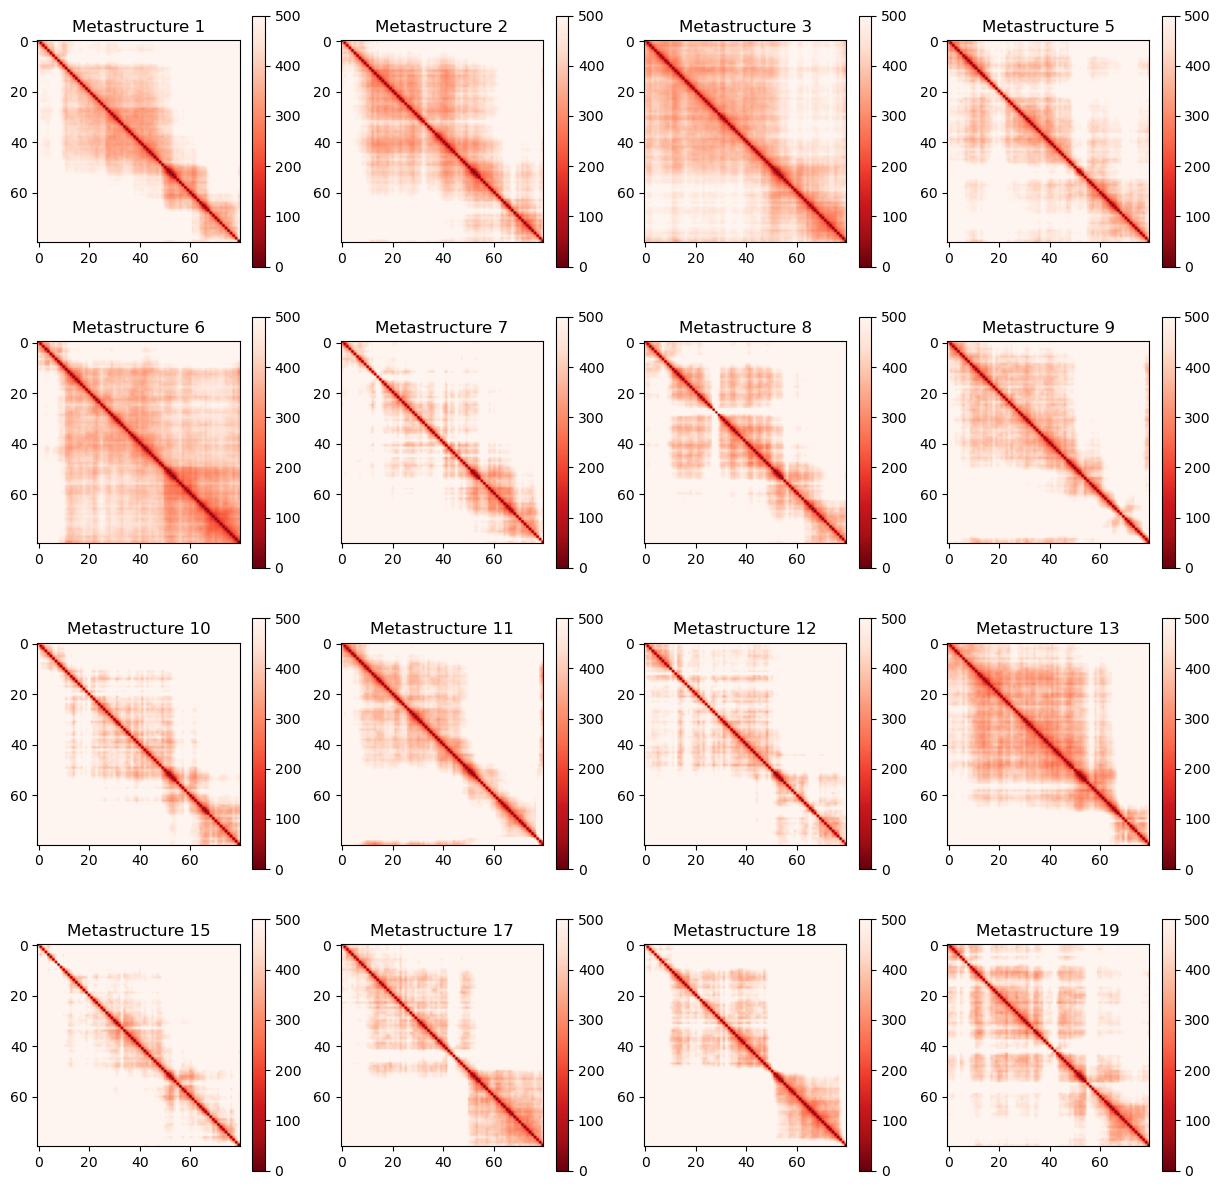

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(cnc_metastructures[i].reshape(-1, 80), cmap='Reds_r', vmax=500)
    ind = np.arange(1, 251)[cnc_indices][i]
    ax.set_title(f'Metastructure {ind}')
    fig.colorbar(im, ax=ax)
plt.savefig(os.path.join(save_dir, 'cnc_enriched_metastructures.png'), dpi=300, bbox_inches='tight')

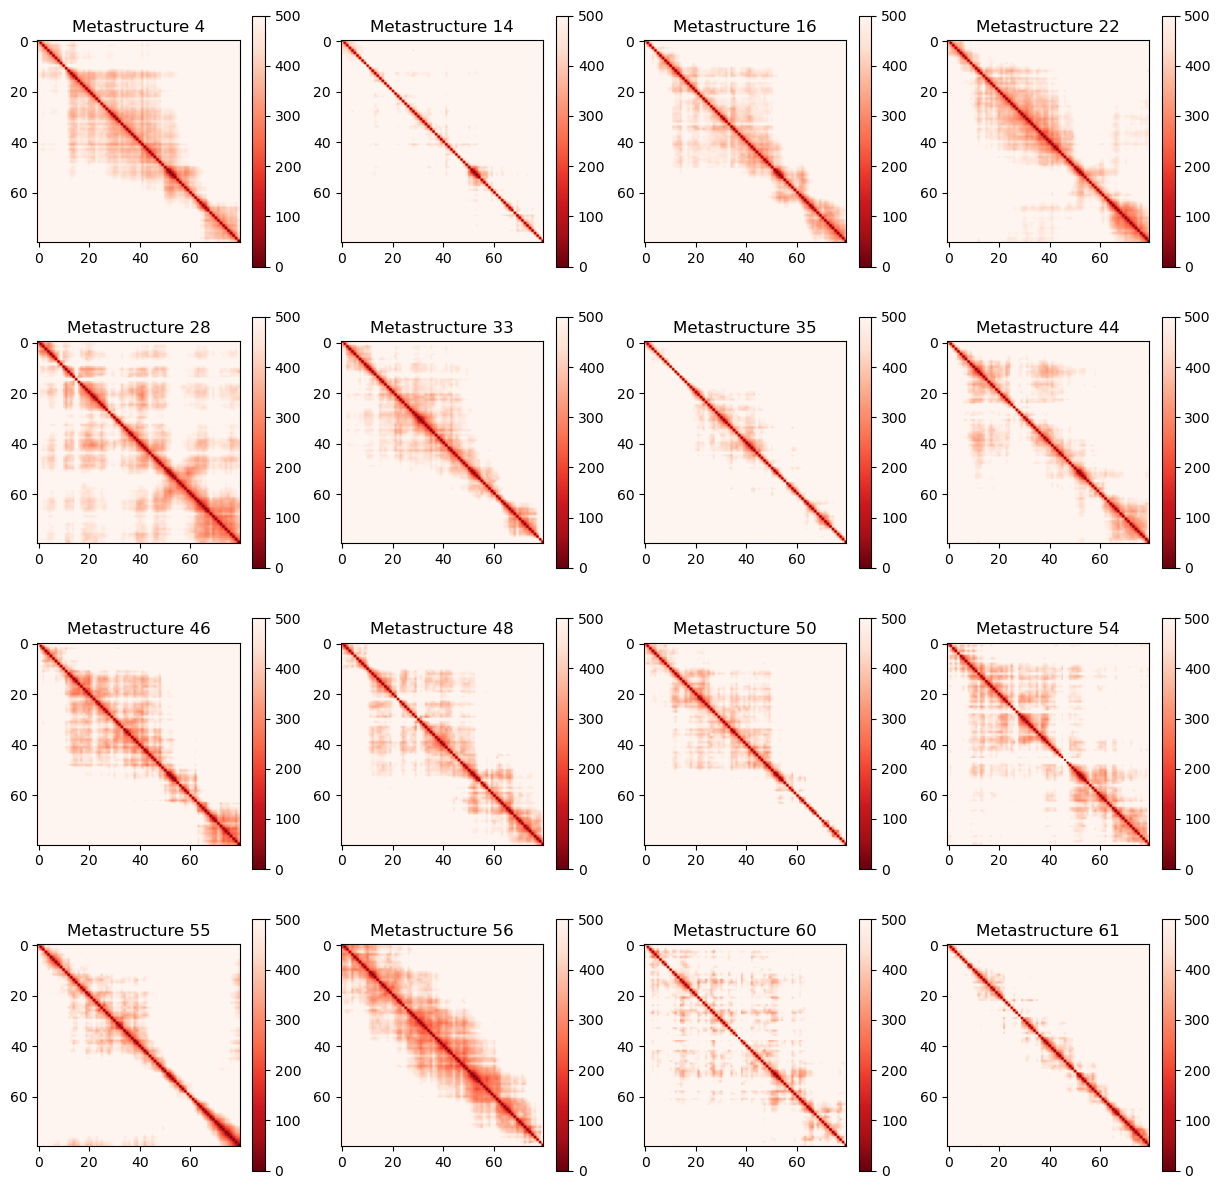

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(esc_metastructures[i].reshape(-1, 80), cmap='Reds_r', vmax=500)
    ind = np.arange(1, 251)[esc_indices][i]
    ax.set_title(f'Metastructure {ind}')
    fig.colorbar(im, ax=ax)
plt.savefig(os.path.join(save_dir, 'esc_enriched_metastructures.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_289053/4109534642.py:2: RuntimeWarning: divide by zero encountered in divide
  cnc_ratio = num_comp_sorted_cnc / num_comp_sorted_esc


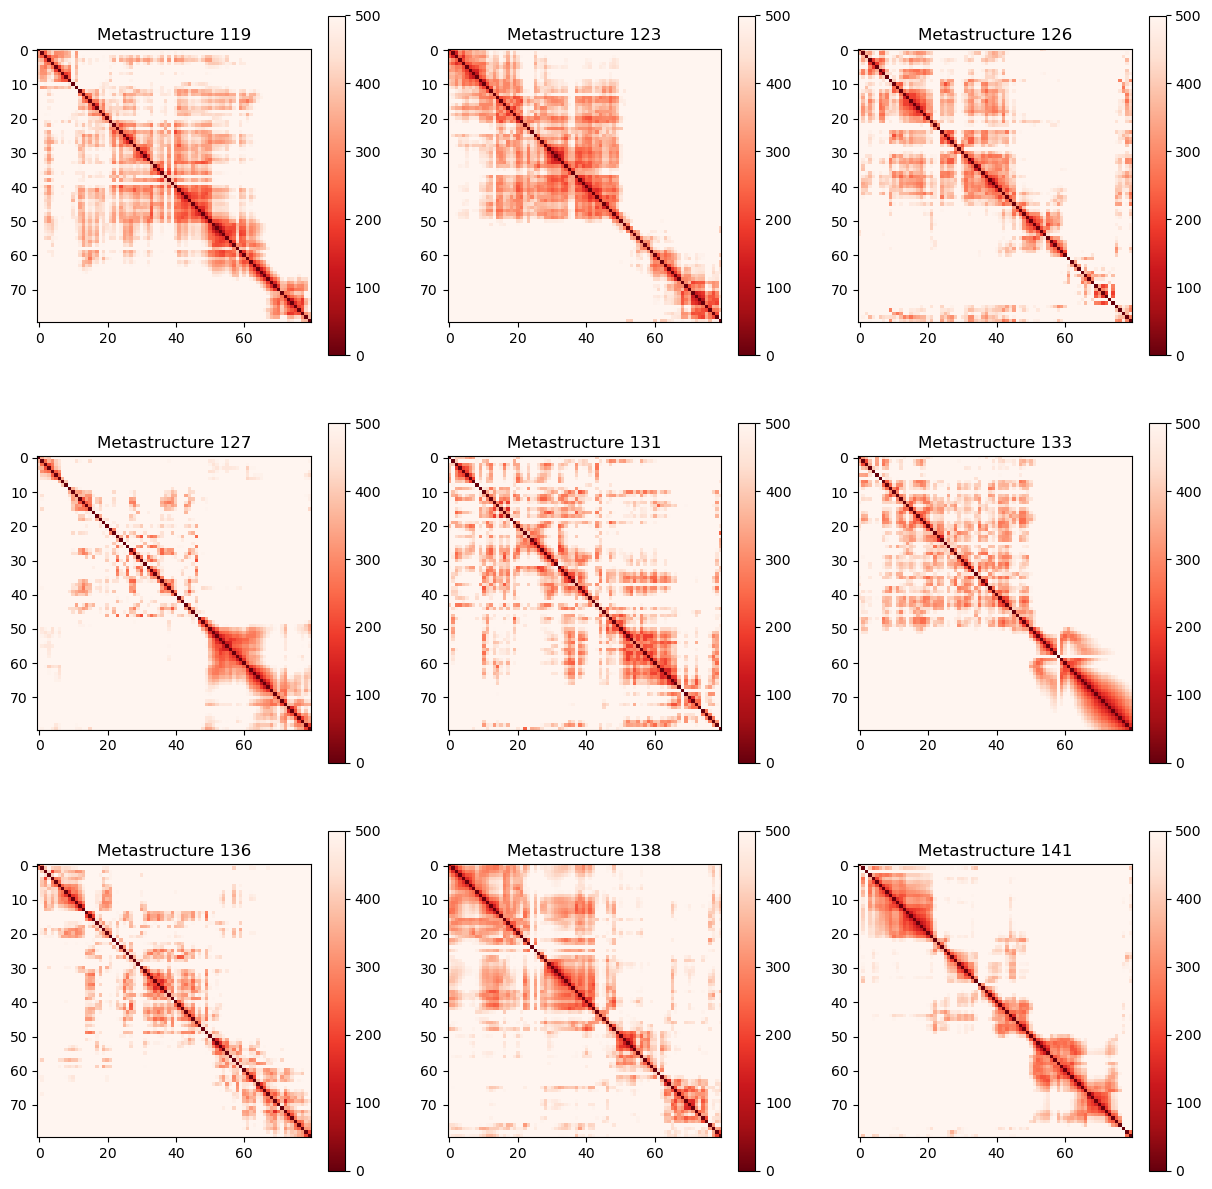

In [ ]:
# Plot the CNC metastructures whose ratio is 90th percentile 
cnc_ratio = num_comp_sorted_cnc / num_comp_sorted_esc
cnc_ratio_sorted = cnc_ratio[np.argsort(cnc_ratio)]
cnc_ratio_90 = cnc_ratio_sorted[int(0.9 * len(cnc_ratio))]
cnc_ratio_90_indices = np.where(cnc_ratio >= cnc_ratio_90)[0]

cnc_ratio_90_metastructures = means_sorted[cnc_ratio_90_indices]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(cnc_ratio_90_metastructures[i].reshape(-1, 80), cmap='Reds_r', vmax=500)
    ind = np.arange(1, 251)[cnc_ratio_90_indices][i]
    ax.set_title(f'Metastructure {ind}')
    fig.colorbar(im, ax=ax)
    
plt.savefig(os.path.join(save_dir, 'cnc_ratio_90_metastructures.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_289053/1774417611.py:2: RuntimeWarning: divide by zero encountered in divide
  cnc_ratio = num_comp_sorted_cnc / num_comp_sorted_esc


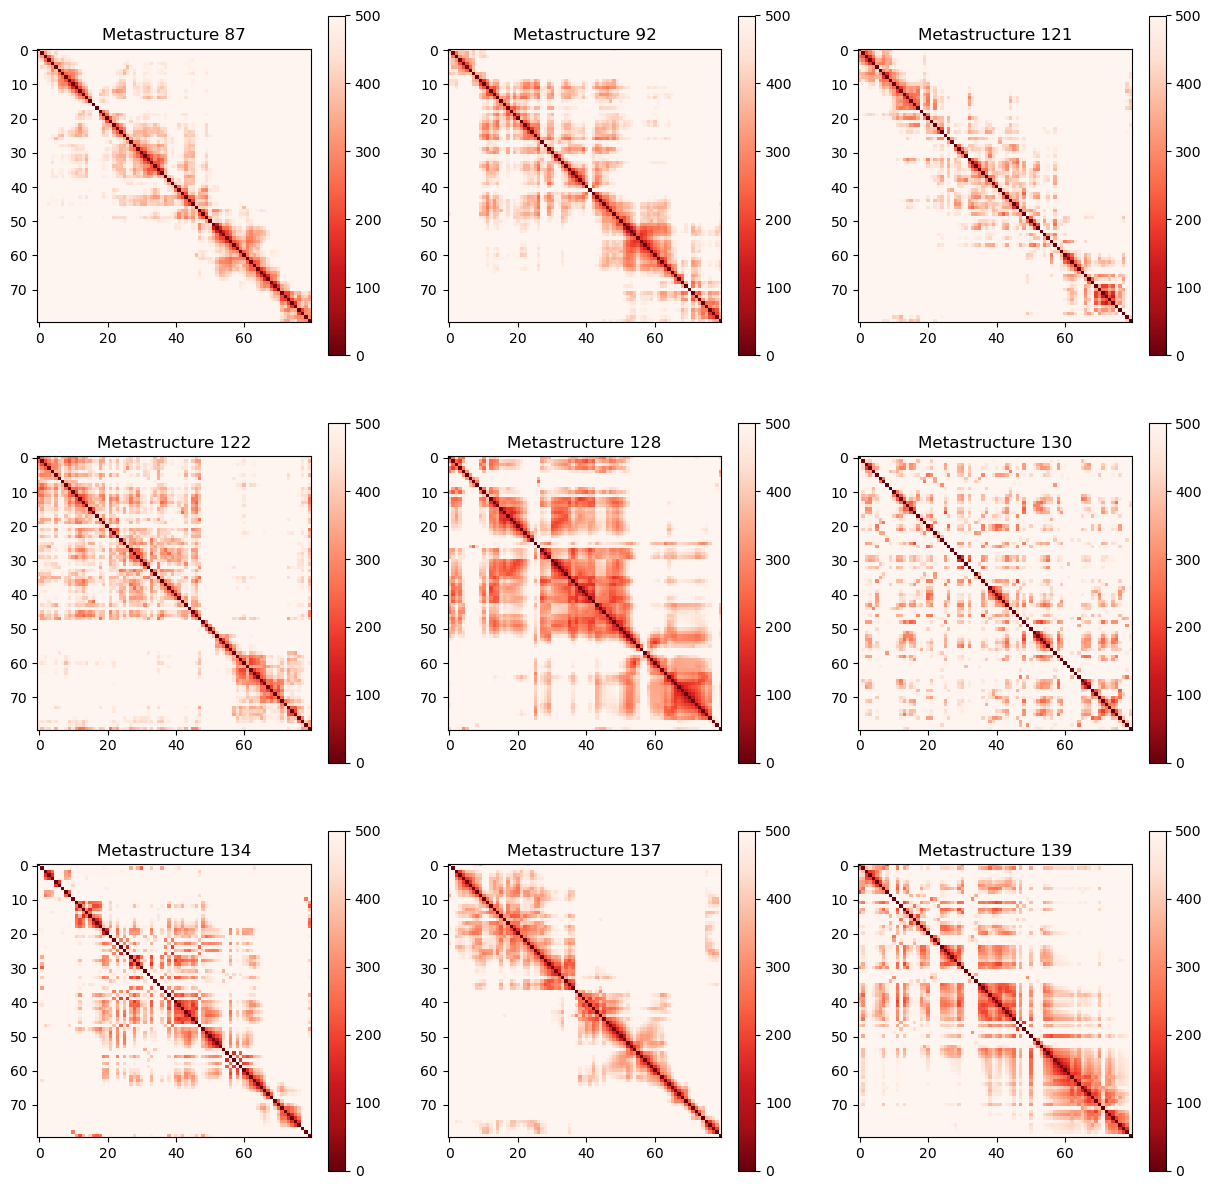

In [ ]:
# Plot the ESC metastructures whose ratio is 90th percentile 
cnc_ratio = num_comp_sorted_cnc / num_comp_sorted_esc
cnc_ratio_sorted = cnc_ratio[np.argsort(cnc_ratio)]
cnc_ratio_10 = cnc_ratio_sorted[int(0.1 * len(cnc_ratio))]
cnc_ratio_10_indices = np.where(cnc_ratio <= cnc_ratio_10)[0]

cnc_ratio_10_metastructures = means_sorted[cnc_ratio_10_indices]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(cnc_ratio_10_metastructures[i].reshape(-1, 80), cmap='Reds_r', vmax=500)
    ind = np.arange(1, 251)[cnc_ratio_10_indices][i]
    ax.set_title(f'Metastructure {ind}')
    fig.colorbar(im, ax=ax)
    
plt.savefig(os.path.join(save_dir, 'cnc_ratio_10_metastructures.png'), dpi=300, bbox_inches='tight')

In [ ]:
cov_sorted = fit_result.covariances_[sort_indices, :]

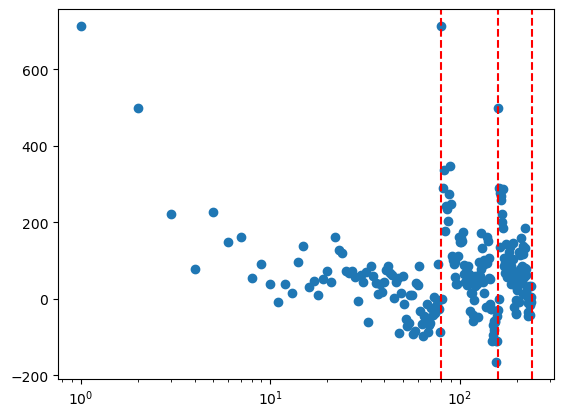

In [ ]:
plt.semilogx(cov_sorted[1, 1, :80*3], 'o')
for i in range(4):
    plt.axvline(i*80, color='red', linestyle='--')

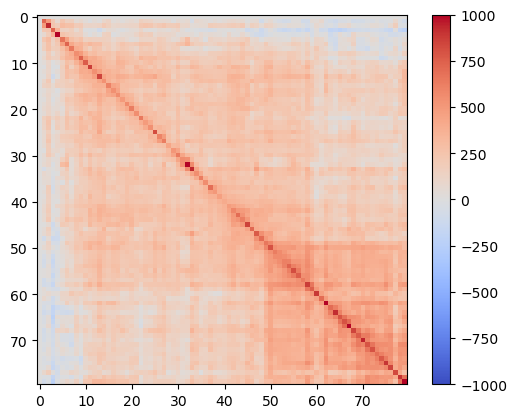

In [ ]:
plt.imshow(cov_sorted[1, :80, :80], cmap='coolwarm', vmax=1000, vmin=-1000)
plt.colorbar()

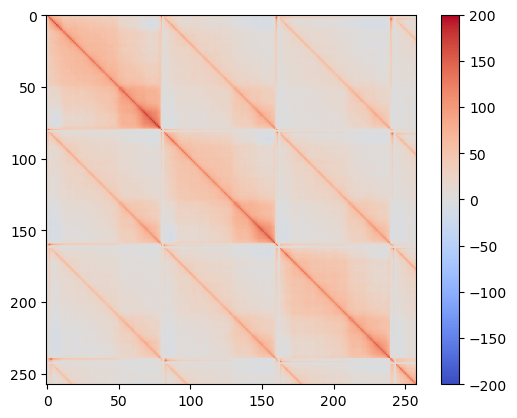

In [ ]:
plt.imshow(np.mean(cov_sorted, axis=0)[:86*3, :86*3], cmap='coolwarm', vmax=200, vmin=-200)
plt.colorbar()

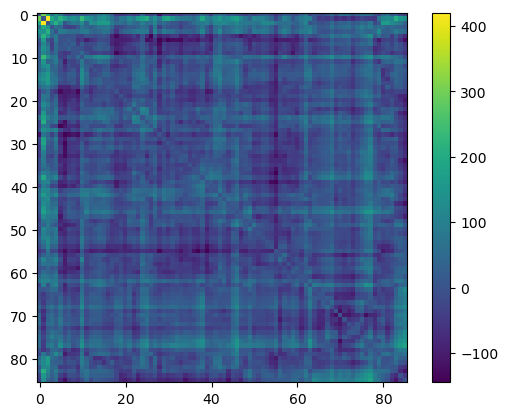

In [ ]:
plt.imshow(cov_sorted[0, 88, :].reshape(86, 86))
plt.colorbar()

In [ ]:
# Initialize UMAP model
umap_model = umap.UMAP(n_components=2)
# Fit UMAP on the first dataset
umap_model.fit(all_maps_interp_flat)
esc_umap = umap_model.transform(esc_maps_interp_flat)
cnc_umap = umap_model.transform(cnc_maps_interp_flat)
all_umap = umap_model.transform(all_maps_interp_flat)

In [ ]:
metastructure_umap = umap_model.transform(means_sorted)

In [ ]:
esc_pd = pd.DataFrame(esc_umap, columns=['UMAP1', 'UMAP2'])
esc_pd = esc_pd.assign(label='ESC')
cnc_pd = pd.DataFrame(cnc_umap, columns=['UMAP1', 'UMAP2'])
cnc_pd = cnc_pd.assign(label='CNC')
metastructure_pd = pd.DataFrame(metastructure_umap, columns=['UMAP1', 'UMAP2'])
metastructure_pd = metastructure_pd.assign(label='Metastructure')
metastructure_pd['weights'] = num_poly_comp_sorted
all_pd = pd.concat([esc_pd, cnc_pd, metastructure_pd])

In [ ]:
observations_pd = pd.concat([esc_pd, cnc_pd])

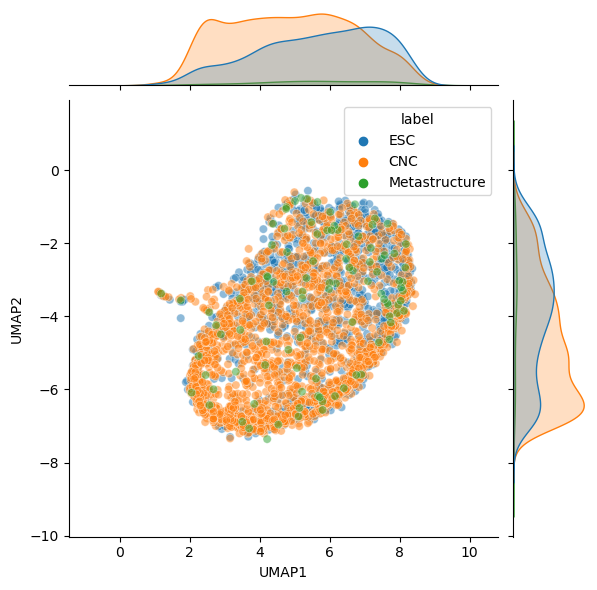

In [ ]:
sns.jointplot(data=all_pd, x='UMAP1', y='UMAP2', hue='label', alpha=0.5)
plt.savefig(os.path.join(save_dir, 'umap.png'), dpi=300, bbox_inches='tight')

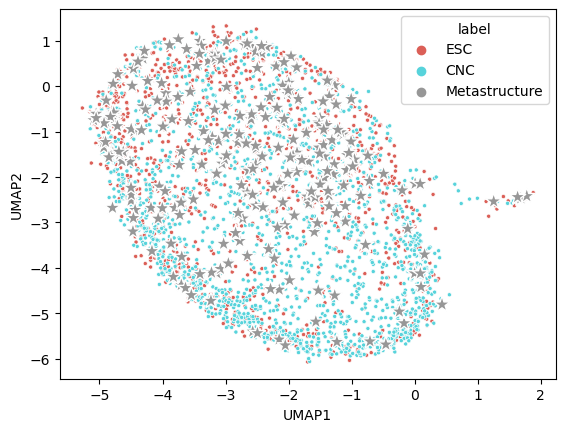

In [ ]:
sns.scatterplot(data=observations_pd, x='UMAP1', y='UMAP2', hue='label', alpha=1, marker='.', palette='hls')
sns.scatterplot(data=metastructure_pd, x='UMAP1', y='UMAP2', hue='label', marker='*', s=150, palette='Greys_r')
plt.savefig(os.path.join(save_dir, 'umap_metastructures.png'), dpi=300, bbox_inches='tight')

In [46]:
sample_means, sample_clusters = fit_result.sample(10000)

KeyboardInterrupt: 

In [ ]:
# Pickle dump sample_means and sample_clusters 
pkl_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset'
sample_dict = {
    'n': 10000,
    'means': sample_means,
    'clusters': sample_clusters
}
pickle.dump(sample_dict, open(os.path.join(pkl_path, 'bgmm_sampling.pkl'), 'wb'))
